In [ ]:
# Start writing code here...

In [ ]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from lib.viz import draw_missing_data_chart, draw_corr_heatmap, draw_components_variance_chart, biplot, draw_feature_importance, draw_histogram

from lib.transform_impute import *
from lib.split_data import group_split, train_test_split_single_level_index
from lib.create_pipeline import create_transformation_pipeline
from lib.read_data import read_feature_files, read_and_join_output_file

from lib.supervised_tuning import predict_score_base_regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


#### If fresh data files need to be generated, delete the existing pickle files

In [ ]:
dir_path = '../assets/train_test_target_shifted/'
file_name = ['X_target_shifted_pca.pickle', 'X_train_impute_target_shifted_df.pkl','X_test_impute_target_shifted_df.pkl', 'train_test_dict_target_shifted.pickle']

# for name in file_name:
#     full_path = f"{dir_path}{name}"
#     #print(full_path)
#     file_exists = os.path.exists(full_path)
#     #print(f"File Exists: {file_exists}")
#     if file_exists:
#         os.remove(full_path)



#### Read data from each table and combine/join with keys

In [ ]:
all_features_target_df = read_and_join_output_file(start_year=2014, end_year=2021)
print(all_features_target_df.shape)
#There are 81 columns and the index is a combination of township range and year that is separate from these columns

(3824, 81)


> The current year's groundwater depth is a feature in the dataset. The depth is shifted that is the next year's depth is the target for prediction for the current year's features.

In [ ]:
#Create a copy of the current year's GSE_GWE as a feature. The target will be shifted for prediction
all_features_target_df['CURRENT_DEPTH'] = all_features_target_df['GSE_GWE']

### Some ideas for feature engineering that were considered
- Adding the year as a feature: but then it becomes a category, so add number of periods in years from the year 2014 (duration), but in prediction, 2014 is the base point for prediction.
- Adding drought years : We only have a visually inspected chart dataset for this and so this is tricky
- Adding selected features (as identified by correlation, shapely and feature importance in previous iterations)-implemented.
- Adding a shifted lagged version of the target as a feature. Since we have only a few years of data and shifting will create nulls, this might be tricky.- implemented by changing the year of prediction to 2021
- [Rolling Window Statistics](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
- A step beyond adding raw lagged values is to add a summary of the values at previous time steps.We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean. This again means losing year 2014 since we do not have information for year 2013. Also we will have to include a feature to add after imputing?
- Have elements of the time series drawn out such as amplitude, standard deviation, median as in the case of an EEG example provided in Chapter 2 of Practical Time Series Analysis.   


## Shifting the Prediction Target To Convert Time Series to a Supervised Learning Problem

In his article [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/), Jason Brownlee describes how to convert time series data to use classic machine learning supervised learning algorithms.

The method used to capture part of the intrinsic time series nature of the data, the target variable is preserved as an input and the target becomes the target variable itself shifted by one time stamp.
Instead of predicting Y(t) based on on the features X1(t) - X4(t),

![Classic ML Prediction](../doc/images/ml_classic_target_prediction.jpg)

the output Y(t) is then predicted based on the previous value of the features (X1(t-1) - X4(t-1)) but also based on it’s own previous value Y(t-1).

![ML Prediction with Target Shifted by 1](../doc/images/ml_shifted_target_prediction.jpg)

This results in the following dataset transformation.

![Shifted Target Dataset Transformation](../doc/images/ml_shifted_target.jpg)

The current year's features of well details, precipitation, reservoir level, vegetation, crops and groundwater depth `GSE_GWE` are used to predict next year's groundwater depth `GSE_GWE`.

From Practical Time Series:
> Suppose, for example, we were building a model that uses email behavior to predict a member's next donation. In this case we might consider looking at the pattern of email opening over time as a possible indicator.
> We would need to line up a given week's donation with the previous week's email behavior. We can easily take our data, processed to align week-to-week, and then shift by the appropriate number of weeks.
> If, say, we want to shift the donation a week forward, we can easily do so with the shift operator, although we would need to be sure to do this on a per-member basis

Note that by shifting the target into the past, we end up having one less year of data since we do not have 2022 data for the year 2021 which was being used earlier as the test set.
Following this transformation:
 * the training set now ranges from 2014-2019 features with the 2015-2020 groundwater depth as the targets
 * the test set is the year 2020 features with the 2021 groundwater depth as a target.

### Feature selection

The below set of features was selected from:
-  the list of features highly correlated to the target
- prior iterations of study of the feature importance reflected by algorithms highlighted by manual and automated (PyCaret) methods 
- and Shapely feature importance which is model agnostic,
- as well as top four constituents of PCA components capturing maximum variance of data.

> Note this project was performed in the classic data science project paradigm where we went through several rounds of running the data through the algorithms, evaluation and circling back to the features after capturing those that contribute to the prediction the most and repeating the runs and evaluations. Hence the list of features are a result of multiple iterations.

In [ ]:
feature_subset = list (set ([
'CURRENT_DEPTH'
,'GROUNDSURFACEELEVATION_AVG'
,'TOTALCOMPLETEDDEPTH_AVG'
,'BOTTOMOFPERFORATEDINTERVAL_AVG'
,'TOPOFPERFORATEDINTERVAL_AVG'
,'STATICWATERLEVEL_AVG'
,'PCT_OF_CAPACITY'
,'AVERAGE_YEARLY_PRECIPITATION'
,'TOTALDRILLDEPTH_AVG'
,'WELL_COUNT_DOMESTIC'
,'WELL_COUNT_AGRICULTURE'
,'WELLYIELD_AVG'
,'POPULATION_DENSITY'
,'SOIL_HISTOSOLS_C'
,'SOIL_ALFISOLS_D'
,'SOIL_MOLLISOLS_C'
,'SOIL_MOLLISOLS_B'
,'SOIL_INCEPTISOLS_B'
,'SOIL_ENTISOLS_A'
,'SOIL_ENTISOLS_D'
,'SOIL_ENTISOLS_C'
,'SOIL_ENTISOLS_B'
,'SOIL_ARIDISOLS_D'
,'SOIL_ARIDISOLS_B'
,'SOIL_ARIDISOLS_C'
,'VEGETATION_CALIFORNIA_COAST_LIVE_OAK'
,'VEGETATION_NON-NATIVE_HARDWOOD_FOREST'
,'VEGETATION_HARD_CHAPARRAL'
,'VEGETATION_BLUE_OAK-GRAY_PINE'
,'CROP_F16'
,'CROP_I'
,'CROP_V3'
,'CROP_T15'
,'CROP_T10'
,'CROP_T9'
,'CROP_T8'
,'CROP_T6'
,'CROP_D6'
,'CROP_D14'
,'CROP_P1'
,'CROP_P6'
,'CROP_P3'
,'CROP_D12'
,'CROP_F10'
]))



### Study the target variables

##### Shortage

In [ ]:
#To  enable us to view the township and range in the hover tooltip, make a subset of the dataframe

shortage_subset_df = all_features_target_df[['SHORTAGE_COUNT', 'GSE_GWE']].copy()
shortage_subset_df = shortage_subset_df.reset_index()

 

**Observed** 

T21SR28E reports most shortage during the severe drought years of 2014 and 2015 followed by T21SR27E.



In [ ]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"color":{"field":"TOWNSHIP_RANGE","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"x":{"field":"YEAR","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"y":{"field":"SHORTAGE_COUNT","scale":{"type":"linear","zero":true},"sort":null,"type":"quantitative"}},"height":220,"mark":{"tooltip":{"content":"data"},"type":"bar"}}""")

alt.Chart(...)

##### Groundwater levels

- Observed below: a dip in the groundwater levels from 2014 through 2016, the drought years, 
- then an increase until 2020 and followed by a drop in 2021, another sever drought year.

In [ ]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"YEAR","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"GSE_GWE","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"TOWNSHIP_RANGE","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

### Set random state seed for consistency and reproducibility

- Use this random seed for preprocessing

In [ ]:
RANDOM_SEED = 42

### Split the data into train and test 

-  So that we only transform the test data and there is no data leakage
- In the shifted target model, the GSE_GWE value of a township range is shifted back by one year as the prediction. Which means the township range's 2014 values will predict or forecast the 2015 value of GSE_GWE for that township range.

We will use the years 2014-2019 as the train set and the year 2020 as the test set. The known GSE_GWE values of 2021 will be the target prediction for 2020 test set. There are features in the year 2020 and 2021 that are missing and so we will combine the two sets, train and test, to have available to use **past** years data to forward fill the features in the impute test set. The key is that we are not in the learning task here, and this holdout set is the future set, so we are not leaking information back into the past. This range of 2021 year's data can be used to make predictions in the future.

[From Practical Time Series by Aileen Nielsen: We would need to line up a given week’s donation with the previous week’s email behavior.](https://learning-oreilly-com.proxy.lib.umich.edu/library/view/practical-time-series/9781492041641/ch02.html#idm45554611802952)

In [ ]:
#Decide if the feature selection is to be applied or all of the original features
#are to be selected. Evaluation was conducted with all features and feature subset 
#Feature Selection was performed based on correlation coeffecients, PCA, Feature Imporatance indicated in 
#Previous iterations and Shapely Feature Importance.

feature_columns = feature_subset

year_list = list(all_features_target_df.index.get_level_values('YEAR').unique())
train_year_list = year_list[0:len(year_list) - 2]
test_year_list = year_list[-2]
pred_year_list = year_list[-1]

X_train= all_features_target_df.loc[(slice(None),train_year_list),feature_columns].copy()
X_test = all_features_target_df.loc[(slice(None),test_year_list),feature_columns].copy()
X_pred = all_features_target_df.loc[(slice(None),pred_year_list),feature_columns].copy()

y = all_features_target_df.loc[:'GSE_GWE']

#We are shifting the target since we want to predict the future depth with current features
y = all_features_target_df.loc[:, 'GSE_GWE'].reset_index()
y['GSE_GWE_SHIFTED'] = y.groupby(['TOWNSHIP_RANGE'])['GSE_GWE'].shift(-1)
y.set_index(['TOWNSHIP_RANGE', 'YEAR'], inplace=True)
y_train = y.loc[(slice(None),train_year_list),['GSE_GWE_SHIFTED']].copy()
y_test =  y.loc[(slice(None),test_year_list),['GSE_GWE_SHIFTED']].copy()
y_pred =  y.loc[(slice(None),pred_year_list),['GSE_GWE_SHIFTED']].copy()


# The below two dataframes are being created for imputation purposes and to avoid data leakage
full_X  = X_train.append(X_test)
full_pred_X = full_X.append(X_pred)

In [ ]:
print(f"Training Years: {train_year_list}\nTesting Year: {test_year_list}\nPrediction Year: {pred_year_list}")

Training Years: ['2014', '2015', '2016', '2017', '2018', '2019']
Testing Year: 2020
Prediction Year: 2021


### Preprocessing Data


In [ ]:
draw_missing_data_chart(X_train)

alt.LayerChart(...)

##### Note that in the prediction set unlike the train and test set, POPULATION_DENSITY is an additional column that is missing values

In [ ]:
draw_missing_data_chart(X_pred)

alt.LayerChart(...)

##### Decision on imputation to be applied to missing variables
 
We have several variables that are null as seen in the chart above.
----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Vegetation dataset**

**Cause** We do not have data for the above vegetation after 2014 for any of the TownshipRanges. That is it is absent for the years [2015, 2016, 2017, 2018, 2019, 2020, 2021]. 

**Imputation**
We will be making an assumption that the vegetation landscape of a TownshipRange does not radically differ from year to year. The vegetation values will carry over from 2014 for these vegetation types for each of the township ranges.  The imputation is carried out by finding the mean of the data for all Townships. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**Crops dataset** 

- For all Crops features

**Cause** We only data for 3 years over the analysis survey, 2014, 2016, 2018

**Imputation**
 We assume little year-to-year variation in crop farming and extended the data for the missing years (2015, 2017, 2019) with the data from the previous years (i.e. we assume that 2015 crops = 2014 crops). We understand that farming practices like crop rotation would challenge these assumptions. The imputation is carried out by sorting the dataframe by year and then township and then forward filling the data over to the years following.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Soils dataset**

**Cause**  We have data for soils for 2016 and not for other years. 

**Imputation**
We will be making an assumption that the basic nature of the soil of a TownshipRange does not radically differ from year to year. As we do not expect the soil type to change from year, the 2016 soil data are used for all the other years. The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**WELL COMPLETION**

**Cause** Absence of well completion reports filed in township range in certain, or all years causes values to be null

**Imputation**

We impute the GROUNDSURFACEELEVATION_AVG (that is part of the well completion report) for a TownshipRange as the mean of the values over all years for that TownshipRange. This value that is stored in the data is the average of the elevation of the ground where wells were constructed in that TownshipRange and hence elevation was known. 

But this does not cover all the NaNs since 76 TRs do not have any value at all and  they should be filled with the average elevation of the entire area.

For the other variables since they are the **average** of the well yield, static water level, top of perforated interval, bottom of perforated interval and total completed depth of the wells constructed in each TownshipRange and so if there are **no wells newly constructed**, in a township range in a certain year, **this value will be set to 0** as these variables are well specific measurements. 


----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**RESERVOIR**

**Cause** Reservoir data is available from the California reporting stations from 2018, we are missing the data from 2014 through 2017.  

**Imputation**
Since in these years, California was stricken with drought, we will impute the values to be the **minimum** of the PCT_OF_CAPACITY for that TownshipRange.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**POPULATION**

**Cause** Population density is missing for the final year of 2021 for all townships.

**Imputation**
We will be using the previous years(2020's) trend over the year 2019 and add to the previous years (2020) value for each TownshipRanges  for the missing values in year 2021.






____________________________________________________________________________________________________
____________________________________________________________________________________________________


**NOTE**:
[Reference article](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a)
>Pipeline steps are executed serially, where the output from the first step is passed to the second step, and so on.
> ColumnTransformers are different in that each step is executed separately, and the transformed features are concatenated at the end.
>By default, any columns you pass into the ColumnTransformer that aren’t specified to be transformed will be dropped (remainder='drop'). If you have columns that you want to include but do not need to be transformed, specify remainder='passthrough'.


#### Transformation

- FunctionTransformers : enable working with a set of columns and applying transormation particular to them
- Extending the base estimator class : extends the fit and transform functionality of the BaseEstimator and transformer class
- We have a choice between Standard and Min-Max scaler. Some of the algorith require data to be centered and normalized - PCA and UMAP for instance. I have chosen StandardScaler below for that reason. 

### Impute missing Data and Scale numeric data

- Standard Scaling : Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as:
z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

- SVM and StandardScaling
Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

- MinMaxScaling 
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

In [ ]:
#We can try different scores with MinMaxScaler and StandardScaler
# I have stored the output of imputing and scaling using StandardScaler and run SVM
#Now trying out MinMaxScaler
impute_pipe = create_transformation_pipeline(X_train, scaler = StandardScaler())
X_train_impute = impute_pipe.fit_transform(X_train)

In [ ]:
set_config(display="diagram")
display(impute_pipe)

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('wcr',
                                 Pipeline(steps=[('imputer',
                                                  PandasSimpleImputer(fill_value=0,
                                                                      strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['TOTALDRILLDEPTH_AVG', 'WELLYIELD_AVG',
                                  'STATICWATERLEVEL_AVG',
                                  'TOPOFPERFORATEDINTERVAL_AVG',
                                  'BOTTOMOFPERFORATEDINTERVAL_AVG',
                                  'TOTALCOMPLETEDDEPTH_AVG']),
                                ('veg',
                                 FunctionTran...
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(aggregation_func='min',
                                                               group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='PCT_OF_CAPACITY')),
                                                 ('scaler', StandardScaler())]),
                                 ['PCT_OF_CAPACITY']),
                                ('gse',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='GROUNDSURFACEELEVATION_AVG')),
                                                 ('scaler', StandardScaler())]),
                                 ['GROUNDSURFACEELEVATION_AVG'])])

### Convert the numpy array to dataframe to view the columns imputation results

In [ ]:
X_train_impute_df = convert_back_df(
    X_train_impute,
    impute_pipe,
    X_train,
)
draw_missing_data_chart(X_train_impute_df)
X_train_impute_df.to_pickle('../assets/train_test_target_shifted/X_train_impute_target_shifted_df.pkl')

### Make sure the test set is now withdrawn from the full set

In [ ]:
X_full_impute = impute_pipe.transform(full_X)
full_impute_df = convert_back_df(
    X_full_impute,
    impute_pipe,
    full_X
)
#Use the test years
X_test_impute_df = full_impute_df.loc[(slice(None),test_year_list),:].copy()
X_test_impute_df.to_pickle('../assets/train_test_target_shifted/X_test_impute_target_shifted_df.pkl')

X_test_impute = X_test_impute_df.values 
draw_missing_data_chart(X_test_impute_df)

alt.LayerChart(...)

### Impute the prediction features

In [ ]:
X_pred_impute = impute_pipe.transform(full_pred_X)
pred_impute_df = convert_back_df(
    X_pred_impute,
    impute_pipe,
    full_pred_X
)
#Use the test years
X_pred_impute_df = pred_impute_df.loc[(slice(None),pred_year_list),:].copy()
X_pred_impute_df.to_pickle('../assets/train_test_target_shifted/X_pred_impute_target_shifted_df.pkl')

X_pred_impute = X_pred_impute_df.values 
draw_missing_data_chart(X_pred_impute_df)

alt.LayerChart(...)

### Find feature correlation 

In [ ]:
draw_corr_heatmap(X_train_impute_df.reset_index(), ['TOWNSHIP_RANGE', 'YEAR'])

alt.Chart(...)

#### Co-related features observations

Well construction specific correlations that can be considered as expected since each value describes the well's dimensions and capacity

- We are considereing features with absolute value of 0.7 as being highly correlated
- Scrolling to the right of the heatmap, we see TOPOFPERFORATEDINTERVAL and BOTTOMOFPERFORATEDINTERVAL highly correlated
- BOTTOMOFPERFORATEDINTERVAL and TOPOFPERFORATEDINTERVAL are heavily correlated with TOTALCOMPLETEDDEPTH
- TOTALCOMPLETEDDEPTH is correlated with STATICWATERLEVEL

**Well Count**

- This feature was further categorized as Domestic, Agriculture and Public and hence is highly correlated to the categories (WELL_COUNT --> (WELL_COUNT_DOMESTIC, WELL_COUNT_AGRICULTURE))

**Crops**

We observe some few other correlations between
* some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is *peaches/nectarines*
* or between some crops and soils (e.g. 0.61 between `CROP_T31` *potatoes and sweet potatoes* and `SOIL_ENTISOLS_A` soil of hydrographic group *A* corresponding to coarse texture soils with high saturated hydraulic conductivity. This correlation also makes sense since potatoes tend to not grow well in soils retaining too much water.

**Vegetation**

We also see some level of correlation between the different type of forest vegetation. For example `VEGETATION_CANYON_LIVE_OAK`, `VEGETATION_HARD` and `VEGETATION_KNOBCONE_PINE` show correlation values between 0.46 and 0.6. This might be explained by the fact that some type of vegetation tend to live together.




### Dimensionality reduction for multiple vegetation, crops and soil

> Scree plot helps pick out number of components that explain a threshold of variance selected.

In [ ]:
# How many features will it take to explain 70% of the variance
pca = PCA()
X_pca = pca.fit_transform(X_train_impute_df)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_75 = len(total_explained_variance[total_explained_variance >= .75])
n_to_reach_75 = X_train_impute_df.shape[1] - n_over_75 + 1
print(f"Number features: {n_to_reach_75}\tTotal Variance Explained: {total_explained_variance[n_to_reach_75-1]}")

Number features: 6	Total Variance Explained: 0.7588053505067467


In [ ]:
draw_components_variance_chart(pca)

alt.Chart(...)

In [ ]:
print("Cumulative Variances (Percentage):")
print(pca.explained_variance_ratio_.cumsum() * 100)
print()

Cumulative Variances (Percentage):
[ 31.04527131  45.41044407  55.68465142  63.19427057  69.61172524
  75.88053505  81.13718128  86.13395218  89.72836204  92.76169375
  94.88355462  96.05123215  96.64103823  97.15045197  97.57781977
  97.92344702  98.2289447   98.48298209  98.68024073  98.86437257
  99.03648405  99.18563245  99.31788275  99.44102807  99.54545966
  99.63252243  99.71155525  99.77785456  99.83509888  99.87689081
  99.91429136  99.94119958  99.96264586  99.97616382  99.98678513
  99.99001395  99.99302841  99.99570684  99.99704678  99.99824334
  99.99937633  99.99976229  99.99994181 100.        ]



### Use number of components that explain 75% of the variance

In [ ]:
pca = PCA(n_components=n_to_reach_75)
X_train_pca = pca.fit_transform(X_train_impute_df)

In [ ]:
pca_components = abs(pca.components_)
print('Top 4 most important features in each component')
print('===============================================')
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {X_train_impute_df.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['TOTALCOMPLETEDDEPTH_AVG', 'BOTTOMOFPERFORATEDINTERVAL_AVG', 'TOPOFPERFORATEDINTERVAL_AVG', 'STATICWATERLEVEL_AVG']
Component 1: ['WELL_COUNT_DOMESTIC', 'CURRENT_DEPTH', 'GROUNDSURFACEELEVATION_AVG', 'WELL_COUNT_AGRICULTURE']
Component 2: ['PCT_OF_CAPACITY', 'AVERAGE_YEARLY_PRECIPITATION', 'WELL_COUNT_AGRICULTURE', 'WELL_COUNT_DOMESTIC']
Component 3: ['AVERAGE_YEARLY_PRECIPITATION', 'GROUNDSURFACEELEVATION_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_DOMESTIC']
Component 4: ['TOTALDRILLDEPTH_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_AGRICULTURE', 'GROUNDSURFACEELEVATION_AVG']
Component 5: ['POPULATION_DENSITY', 'TOTALDRILLDEPTH_AVG', 'PCT_OF_CAPACITY', 'CURRENT_DEPTH']


> Biplot to visualize PCA orientations and scores 

<module 'matplotlib.pyplot' from '/root/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

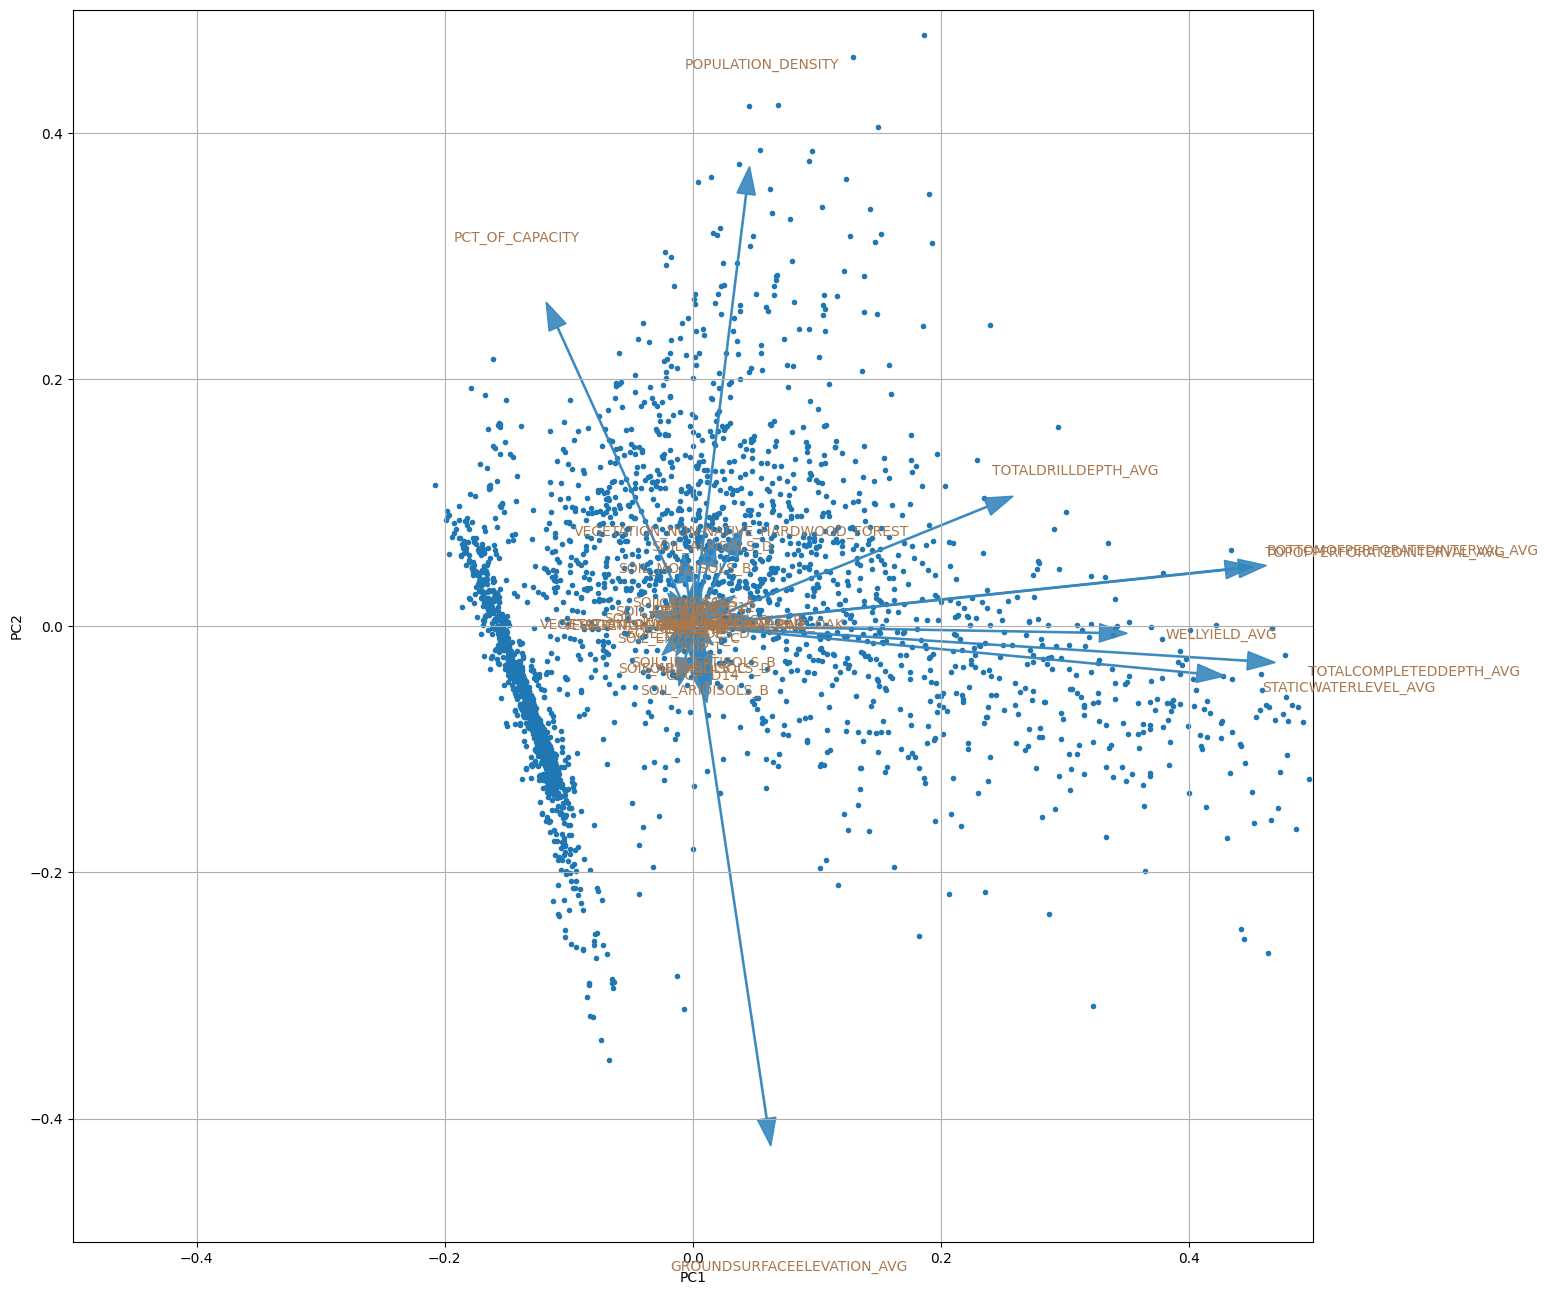

In [ ]:
feature_subset_count = 40
feature_names=list(X_train_impute_df.columns)
feature_subset = slice(0, feature_subset_count, 1)

biplot(X_train_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

   

In the data transformed by StandardScaler, the dimensionality reduction after feature selection shows components created that  have a real world interpretebility. We do see here that the well characteristics are aligned with minimal angle between them, which indicates high cosine similarity, with a higher difference to TOTALDRILLDEPTH_AVG.

We see GROUNDSURFACELEVATION_AVG shows high variance in data in a direction opposing population density and reservoir capacity, the latter two showing similr directions in dt variation. Variance is also captured by well characteristics features like STATICWATERLEVEL_AVG and TOTALCOMPLETEIONDEPTH_AVG which also are correlated with WELLYIELD_AVG   

In [ ]:
X_test_pca= pca.transform(X_test_impute)

In [ ]:
file_exists = os.path.exists('../assets/train_test_target_shifted/X_target_shifted_pca.pickle')

if not file_exists:
    train_test_dict = {"X_train_pca": X_train_pca, 
                      "X_test_pca": X_test_pca,
                      "y_train": y_train,
                      "y_test": y_test,
                }

    with open('../assets/train_test_target_shifted/X_target_shifted_pca.pickle', 'wb') as file:
        pickle.dump(train_test_dict, file)

###  Feature Importance

In [ ]:
col_list = [col for col in X_train_impute_df if "TOWNSHIP_RANGE" not in col  and 'YEAR' not in col]
rfreg = RandomForestRegressor().fit(X_train_impute_df[col_list], y_train)
draw_feature_importance(col_list, rfreg.feature_importances_)

/tmp/ipykernel_642/2072139797.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfreg = RandomForestRegressor().fit(X_train_impute_df[col_list], y_train)


alt.Chart(...)

In [ ]:
#Store the train and test sets in pickle files

file_exists = os.path.exists('../assets/train_test_target_shifted/train_test_dict_target_shifted.pickle')

if not file_exists:
    train_test_dict = {"X_train_impute": X_train_impute, 
                      "X_test_impute": X_test_impute,
                      "X_pred_impute": X_test_impute,
                      "y_train": y_train,
                      "y_test": y_test,
                      "y_pred": y_pred
                }

    with open('../assets/train_test_target_shifted/train_test_dict_target_shifted.pickle', 'wb') as file:
        pickle.dump(train_test_dict, file)




> Note the keys of the dictionary of data stored that will be used in Supervised and Unsupervised Learning

In [ ]:
train_test_dict.keys()

dict_keys(['X_train_impute', 'X_test_impute', 'X_pred_impute', 'y_train', 'y_test', 'y_pred'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>